# Semi-supervised Learning Pipeline: AQI Classification

Notebook này thực hiện toàn bộ quy trình từ xử lý dữ liệu, baseline, self-training, co-training, ensemble và báo cáo kết quả.

**Mục tiêu:**
1.  **Data:** Chia 30% Labeled / 70% Unlabeled.
2.  **Baseline:** Supervised Learning trên 30% dữ liệu.
3.  **Self-Training:** Cải thiện model bằng pseudo-labeling.
4.  **Co-Training:** Sử dụng 2 views (Time+Lag vs Weather).
5.  **Ensemble:** Kết hợp kết quả.
6.  **Report:** Báo cáo học thuật.

In [6]:
# Cấu hình hiển thị và import thư viện
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Thêm thư mục src vào path để import các module có sẵn
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath(".."))

from src.classification_library import (
    load_beijing_air_quality,
    clean_air_quality_df,
    add_pm25_24h_and_label,
    add_time_features,
    add_lag_features,
    time_split,
    train_classifier,
    AQI_CLASSES
)

from src.semi_supervised_library import (
    SemiDataConfig,
    SelfTrainingConfig,
    CoTrainingConfig,
    SelfTrainingAQIClassifier,
    CoTrainingAQIClassifier,
    build_feature_columns,
    _normalize_missing
)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Thiết lập style biểu đồ
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## PHẦN 1: XỬ LÝ DỮ LIỆU

1. Load dataset.
2. Làm sạch & Feature Engineering (Time + Lag).
3. Chia Train/Test theo thời gian (Cutoff: 2017-01-01).
4. Giả lập thiếu nhãn: Giữ lại **30% Labeled**, ẩn **70% Unlabeled** trong tập Train.

In [7]:
# 1.1 Load và làm sạch dữ liệu
# Lưu ý: Sử dụng file ZIP local như khuyến nghị trong README
raw_zip_path = "../data/raw/PRSA2017_Data_20130301-20170228.zip"

print("Đang tải dữ liệu...")
df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=raw_zip_path)
df = clean_air_quality_df(df)

# 1.2 Tạo nhãn AQI và đặc trưng thời gian
print("Feature Engineering...")
df = add_pm25_24h_and_label(df)
df = add_time_features(df)

# 1.3 Tạo đặc trưng Lag (PM2.5 lag, Weather lag)
# Lag 1h, 3h, 24h cho các biến môi trường
df = add_lag_features(df, lag_hours=(1, 3, 24))

# Loại bỏ các dòng thiếu nhãn do quá trình rolling window hoặc dữ liệu gốc bị thiếu
df_clean = df.dropna(subset=["aqi_class"]).copy()
print(f"Kích thước dữ liệu sau khi làm sạch: {df_clean.shape}")

Đang tải dữ liệu...
Feature Engineering...
Kích thước dữ liệu sau khi làm sạch: (412935, 55)


In [8]:
# 1.4 Chia Train / Test
CUTOFF = "2017-01-01"
train_df, test_df = time_split(df_clean, cutoff=CUTOFF)

print(f"Train size: {train_df.shape[0]}")
print(f"Test size:  {test_df.shape[0]}")

# 1.5 Giả lập Labeled / Unlabeled (30% / 70%)
# Chúng ta sẽ set nhãn thành NaN cho 70% dữ liệu train
def mask_labels_exact_fraction(df, target_col, labeled_ratio=0.3, random_state=42):
    out = df.copy()
    rng = np.random.default_rng(random_state)
    
    n_total = len(out)
    n_labeled = int(n_total * labeled_ratio)
    
    # Chọn ngẫu nhiên index để giữ nhãn
    labeled_indices = rng.choice(out.index, size=n_labeled, replace=False)
    
    # Set toàn bộ nhãn thành NaN trước
    original_labels = out[target_col].copy()
    out[target_col] = np.nan
    
    # Khôi phục nhãn cho tập labeled
    out.loc[labeled_indices, target_col] = original_labels.loc[labeled_indices]
    
    return out

print("Đang tạo tập dữ liệu bán giám sát (30% labeled)...")
semi_train_df = mask_labels_exact_fraction(train_df, "aqi_class", labeled_ratio=0.3, random_state=42)

n_lbl = semi_train_df["aqi_class"].notna().sum()
n_unlbl = semi_train_df["aqi_class"].isna().sum()
print(f"Số lượng có nhãn (Labeled): {n_lbl} ({n_lbl/len(semi_train_df):.1%})")
print(f"Số lượng mất nhãn (Unlabeled): {n_unlbl} ({n_unlbl/len(semi_train_df):.1%})")

Train size: 396264
Test size:  16671
Đang tạo tập dữ liệu bán giám sát (30% labeled)...
Số lượng có nhãn (Labeled): 118879 (30.0%)
Số lượng mất nhãn (Unlabeled): 277385 (70.0%)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14092\3358805323.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Moderate' 'Moderate' 'Very_Unhealthy' ...
 'Unhealthy_for_Sensitive_Groups' 'Unhealthy' 'Unhealthy']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  out.loc[labeled_indices, target_col] = original_labels.loc[labeled_indices]


## PHẦN 2: BASELINE (Supervised Learning)

Huấn luyện mô hình chỉ trên tập dữ liệu có nhãn (30% Train).
Sử dụng `HistGradientBoostingClassifier` (tương tự LightGBM/XGBoost) có sẵn trong thư viện dự án.

In [9]:
# Lọc chỉ lấy dữ liệu có nhãn để train baseline
baseline_train_df = semi_train_df.dropna(subset=["aqi_class"]).copy()

print("Training Baseline Model...")
baseline_results = train_classifier(baseline_train_df, test_df, target_col="aqi_class")

baseline_metrics = baseline_results["metrics"]
print("\n=== KẾT QUẢ BASELINE ===")
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print(f"Macro F1: {baseline_metrics['f1_macro']:.4f}")

# Lưu kết quả để so sánh sau
results_summary = []
results_summary.append({
    "Method": "Baseline (Supervised 30%)",
    "Accuracy": baseline_metrics['accuracy'],
    "Macro-F1": baseline_metrics['f1_macro']
})

Training Baseline Model...

=== KẾT QUẢ BASELINE ===
Accuracy: 0.6084
Macro F1: 0.4811


## PHẦN 3: SELF-TRAINING

Sử dụng mô hình tự huấn luyện (Self-training) để gán nhãn giả (pseudo-labels) cho tập unlabeled.
- Ngưỡng tin cậy (Confidence Threshold): `tau = 0.9`
- Max iterations: 10

In [10]:
# Cấu hình Self-training
data_cfg = SemiDataConfig(cutoff=CUTOFF, target_col="aqi_class")
st_cfg = SelfTrainingConfig(
    tau=0.90,
    max_iter=10,
    min_new_per_iter=50,
    val_frac=0.2  # Dùng 20% tập labeled để validation nội bộ
)

print("Bắt đầu Self-Training...")
st_model = SelfTrainingAQIClassifier(data_cfg, st_cfg)
st_model.fit(semi_train_df)

# Đánh giá trên tập Test
print("Đánh giá Self-Training trên tập Test...")
# Chuẩn bị dữ liệu test (cần chuẩn hóa giống như lúc train)
feat_cols = st_model.info_["feature_cols"]
X_test = _normalize_missing(test_df[feat_cols].copy())
y_test = test_df["aqi_class"].astype("object")

y_pred_st = st_model.model_.predict(X_test)

acc_st = accuracy_score(y_test, y_pred_st)
f1_st = f1_score(y_test, y_pred_st, average="macro")

print(f"\n=== KẾT QUẢ SELF-TRAINING ===")
print(f"Accuracy: {acc_st:.4f}")
print(f"Macro F1: {f1_st:.4f}")

results_summary.append({
    "Method": "Self-Training",
    "Accuracy": acc_st,
    "Macro-F1": f1_st
})

Bắt đầu Self-Training...
Đánh giá Self-Training trên tập Test...

=== KẾT QUẢ SELF-TRAINING ===
Accuracy: 0.6001
Macro F1: 0.4608


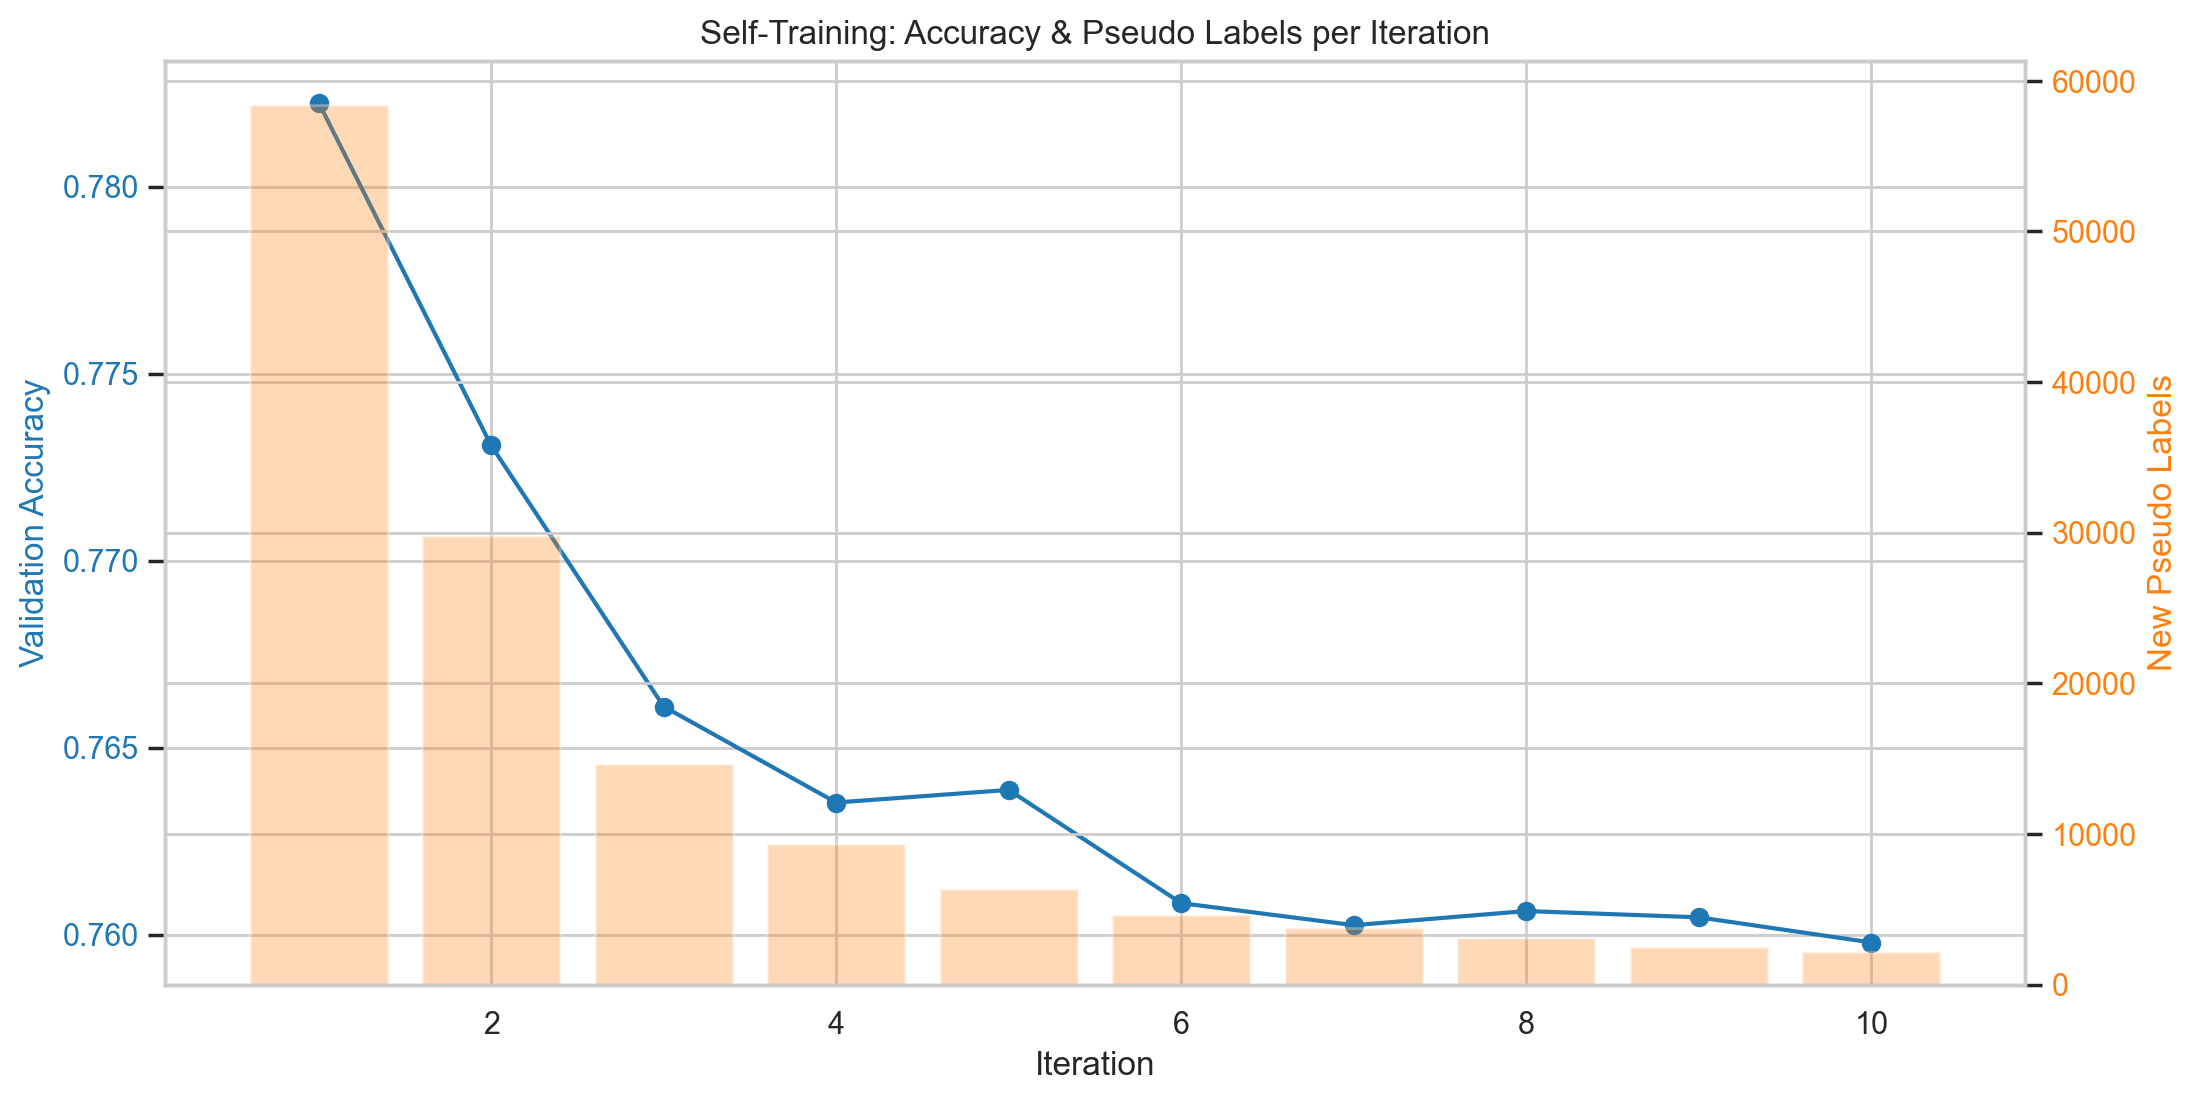

In [11]:
# Trực quan hóa quá trình Self-Training
history_st = pd.DataFrame(st_model.history_)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Validation Accuracy', color='tab:blue')
ax1.plot(history_st['iter'], history_st['val_accuracy'], color='tab:blue', marker='o', label='Val Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('New Pseudo Labels', color='tab:orange')
ax2.bar(history_st['iter'], history_st['new_pseudo'], color='tab:orange', alpha=0.3, label='New Labels')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Self-Training: Accuracy & Pseudo Labels per Iteration')
plt.show()

## PHẦN 4: CO-TRAINING

Tách đặc trưng thành 2 Views riêng biệt:
- **View 1 (Time + Lag):** Thông tin chuỗi thời gian và lịch sử.
- **View 2 (Weather):** Các chỉ số môi trường hiện tại.

Cơ chế:
- Train 2 model riêng biệt.
- Trao đổi nhãn (Exchange labels) khi độ tin cậy >= 0.9.
- Giới hạn max 200 samples mỗi lần thêm (để tránh nhiễu quá nhanh).

In [12]:
# 4.1 Định nghĩa 2 Views
all_cols = train_df.columns.tolist()

# View 1: Time + Lag features
# Lấy các cột lag (có chứa '_lag') và các cột thời gian
view1_cols = [
    "month", "day", "hour", "dow", "is_weekend", "hour_sin", "hour_cos"
] + [c for c in all_cols if "_lag" in c]

# View 2: Weather (Current measurements)
# Các cột đo đạc môi trường gốc (không phải lag)
weather_vars = ["TEMP", "PRES", "DEWP", "RAIN", "WSPM", "SO2", "NO2", "CO", "O3", "PM10"]
view2_cols = [c for c in weather_vars if c in all_cols]

print(f"Số features View 1: {len(view1_cols)}")
print(f"Số features View 2: {len(view2_cols)}")

# 4.2 Cấu hình Co-Training
ct_cfg = CoTrainingConfig(
    tau=0.90,
    max_iter=10,
    max_new_per_iter=200,  # Giới hạn mẫu thêm vào như yêu cầu
    min_new_per_iter=10,
    val_frac=0.2
)

print("\nBắt đầu Co-Training...")
ct_model = CoTrainingAQIClassifier(
    data_cfg, 
    ct_cfg, 
    view1_cols=view1_cols, 
    view2_cols=view2_cols
)
ct_model.fit(semi_train_df)

# 4.3 Đánh giá Co-Training
# Hàm predict của CoTrainingAQIClassifier đã thực hiện việc lấy trung bình xác suất (Soft Voting) của 2 views
y_pred_ct = ct_model.predict(test_df)

acc_ct = accuracy_score(y_test, y_pred_ct)
f1_ct = f1_score(y_test, y_pred_ct, average="macro")

print(f"\n=== KẾT QUẢ CO-TRAINING ===")
print(f"Accuracy: {acc_ct:.4f}")
print(f"Macro F1: {f1_ct:.4f}")

results_summary.append({
    "Method": "Co-Training (2 Views)",
    "Accuracy": acc_ct,
    "Macro-F1": f1_ct
})

Số features View 1: 37
Số features View 2: 10

Bắt đầu Co-Training...

=== KẾT QUẢ CO-TRAINING ===
Accuracy: 0.6056
Macro F1: 0.4902


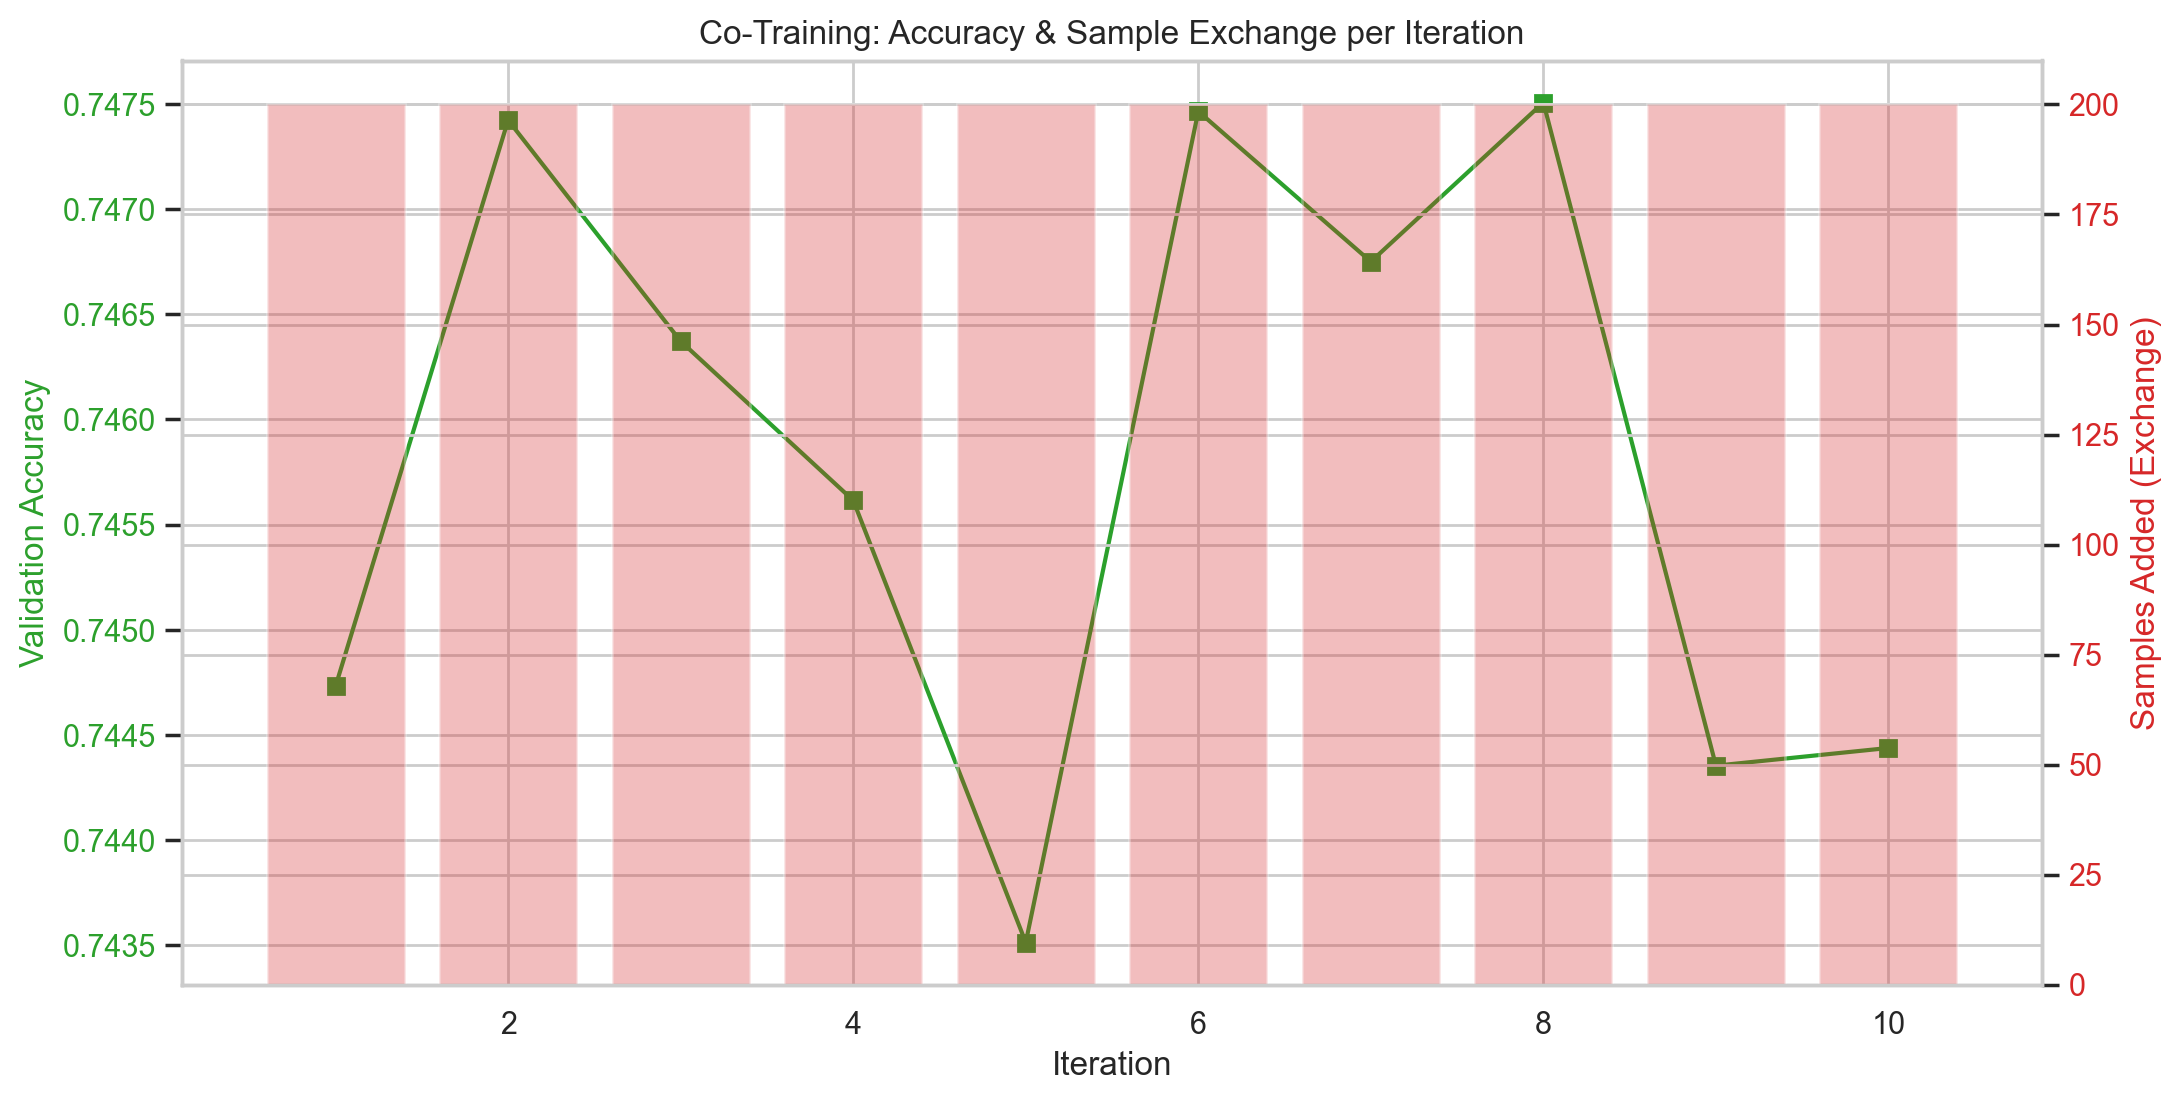

In [13]:
# Trực quan hóa quá trình Co-Training
history_ct = pd.DataFrame(ct_model.history_)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Validation Accuracy', color='tab:green')
ax1.plot(history_ct['iter'], history_ct['val_accuracy'], color='tab:green', marker='s', label='Val Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
ax2.set_ylabel('Samples Added (Exchange)', color='tab:red')
ax2.bar(history_ct['iter'], history_ct['new_pseudo'], color='tab:red', alpha=0.3, label='Samples Added')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Co-Training: Accuracy & Sample Exchange per Iteration')
plt.show()

## PHẦN 5: ENSEMBLE

Kết hợp kết quả từ các mô hình:
1. **M1**: Model từ View 1 (Co-training)
2. **M2**: Model từ View 2 (Co-training)

Phương pháp: **Soft Voting** (Trung bình cộng xác suất dự báo).
*Lưu ý: Trong thư viện `src`, hàm `ct_model.predict()` đã mặc định thực hiện Soft Voting giữa M1 và M2. Ở đây ta sẽ minh họa rõ hơn bằng cách truy xuất từng model.*

In [14]:
# Lấy 2 model con từ Co-Training
model_v1 = ct_model.model1_
model_v2 = ct_model.model2_

# Chuẩn bị dữ liệu cho từng view
X_test_v1 = _normalize_missing(test_df[ct_model.info_["view1_cols"]].copy())
X_test_v2 = _normalize_missing(test_df[ct_model.info_["view2_cols"]].copy())

# Dự báo xác suất (Proba)
proba_v1 = model_v1.predict_proba(X_test_v1)
proba_v2 = model_v2.predict_proba(X_test_v2)

# Cần đảm bảo thứ tự cột xác suất khớp với AQI_CLASSES
# (Hàm helper _align_proba_to_labels trong thư viện đã làm việc này, ta tái sử dụng logic tương tự)
def align_proba(model, proba, labels):
    out = np.zeros((proba.shape[0], len(labels)), dtype=float)
    class_to_pos = {str(c): i for i, c in enumerate(model.named_steps["model"].classes_)}
    for j, lab in enumerate(labels):
        if lab in class_to_pos:
            out[:, j] = proba[:, class_to_pos[lab]]
    return out

p1_aligned = align_proba(model_v1, proba_v1, AQI_CLASSES)
p2_aligned = align_proba(model_v2, proba_v2, AQI_CLASSES)

# Ensemble: Soft Voting
p_ensemble = (p1_aligned + p2_aligned) / 2.0
y_pred_ensemble = np.array(AQI_CLASSES)[p_ensemble.argmax(axis=1)]

acc_ens = accuracy_score(y_test, y_pred_ensemble)
f1_ens = f1_score(y_test, y_pred_ensemble, average="macro")

print(f"\n=== KẾT QUẢ ENSEMBLE (M1 + M2) ===")
print(f"Accuracy: {acc_ens:.4f}")
print(f"Macro F1: {f1_ens:.4f}")

results_summary.append({
    "Method": "Ensemble (Voting)",
    "Accuracy": acc_ens,
    "Macro-F1": f1_ens
})


=== KẾT QUẢ ENSEMBLE (M1 + M2) ===
Accuracy: 0.6056
Macro F1: 0.4902


## PHẦN 6: SO SÁNH KẾT QUẢ

Tổng hợp kết quả từ các phương pháp:
1. Baseline
2. Self-Training
3. Co-Training
4. Ensemble

,Method,Accuracy,Macro-F1
0,Baseline (Supervised 30%),0.608422,0.481084
1,Self-Training,0.600084,0.460830
2,Co-Training (2 Views),0.605603,0.490228
3,Ensemble (Voting),0.605603,0.490228


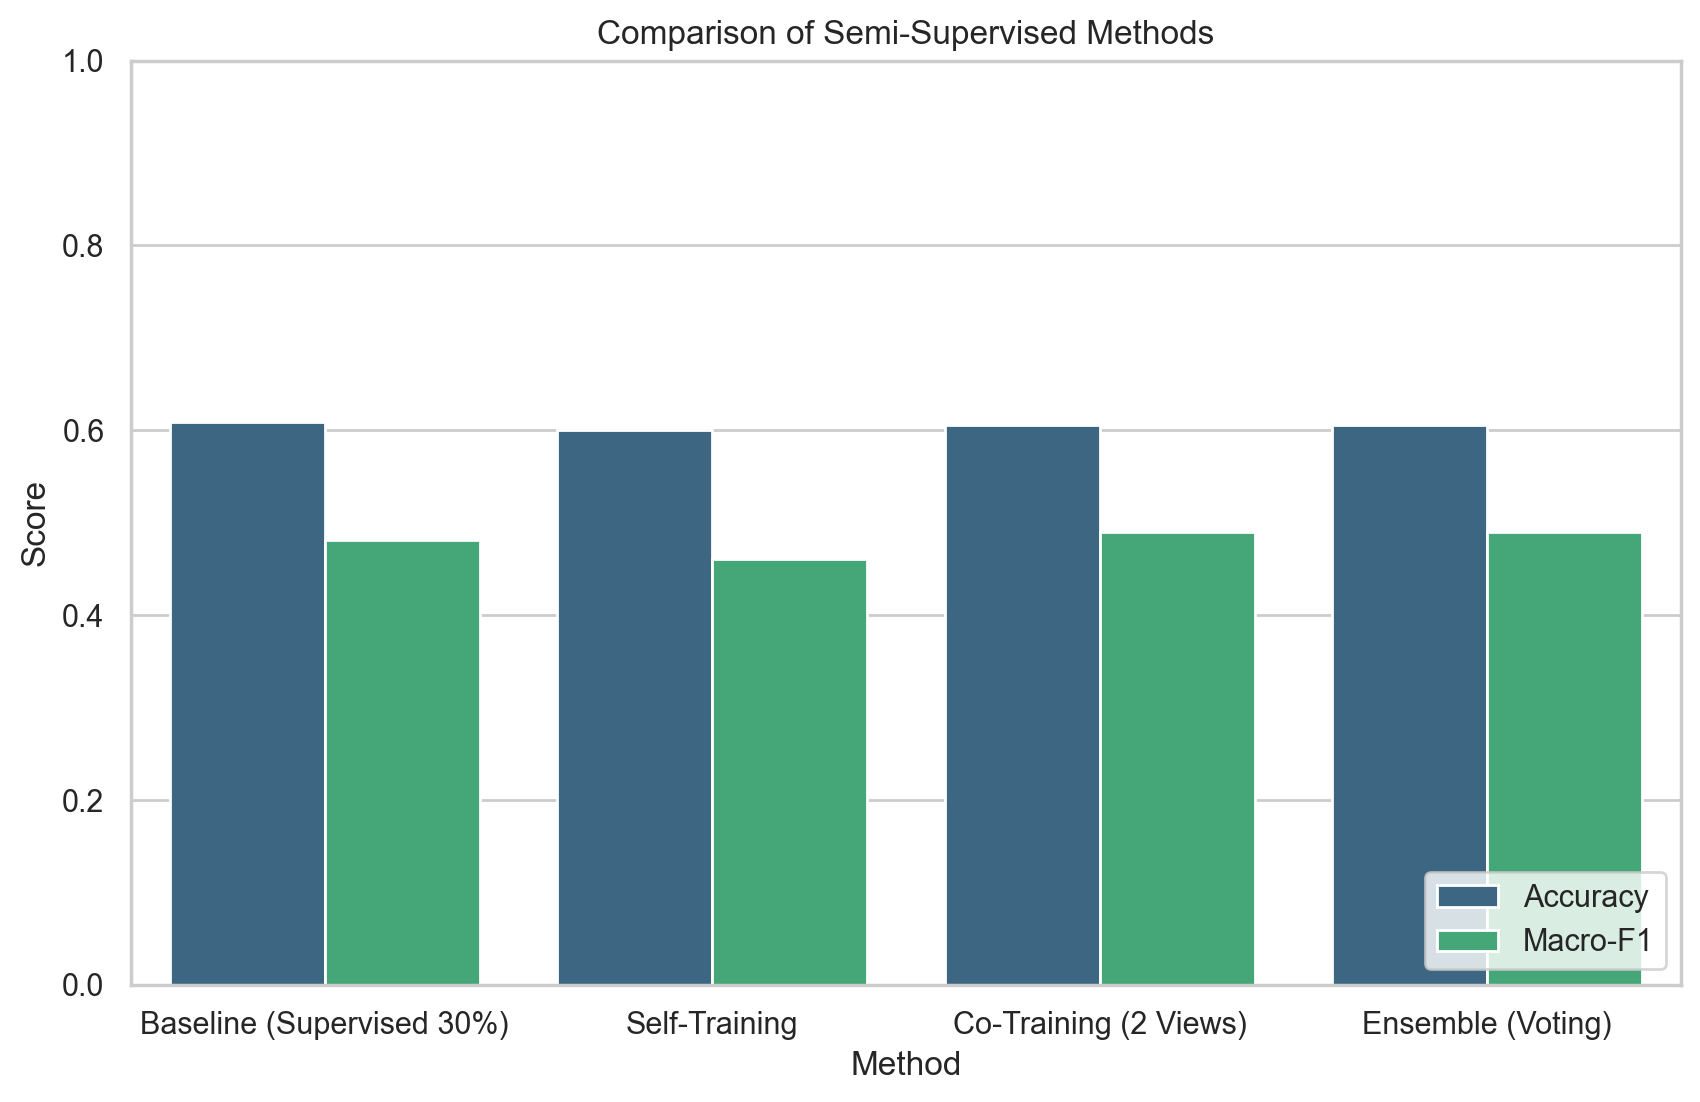

In [15]:
df_res = pd.DataFrame(results_summary)
display(df_res)

# Vẽ biểu đồ so sánh
df_melt = df_res.melt(id_vars="Method", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Method", y="Score", hue="Metric", palette="viridis")
plt.title("Comparison of Semi-Supervised Methods")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## PHẦN 7: BÁO CÁO (ACADEMIC REPORT)

Dưới đây là báo cáo tóm tắt bằng tiếng Việt.

# Học Bán Giám Sát cho Phân Loại Chất Lượng Không Khí: Tiếp Cận Co-Training

## 1. Giới thiệu
Ô nhiễm không khí là vấn đề sức khỏe toàn cầu nghiêm trọng, với PM2.5 là chỉ số chính. Trong khi việc thu thập dữ liệu cảm biến thô được tự động hóa, việc có được nhãn AQI chính xác thường đòi hỏi các trạm tham chiếu đắt tiền hoặc xác nhận thủ công. Dự án này nghiên cứu các kỹ thuật **Học Bán Giám Sát (Semi-Supervised Learning - SSL)**—cụ thể là Self-Training và Co-Training—để tận dụng lượng lớn dữ liệu không nhãn nhằm cải thiện hiệu suất phân loại AQI.

## 2. Dữ liệu & Tiền xử lý
Nghiên cứu sử dụng **Bộ dữ liệu Chất lượng Không khí Đa điểm Bắc Kinh (Beijing Multi-Site Air Quality Dataset)**. 
- **Đặc trưng:** Bộ dữ liệu bao gồm các biến khí tượng (Nhiệt độ, Áp suất, Độ ẩm, Tốc độ gió) và nồng độ chất ô nhiễm (NO2, SO2, CO, O3).
- **Kỹ thuật đặc trưng (Feature Engineering):** Chúng tôi đã xây dựng các đặc trưng dựa trên thời gian (giờ, ngày trong tuần, tính mùa vụ) và các đặc trưng trễ (lag 1h, 3h, 24h) để nắm bắt các phụ thuộc thời gian.
- **Thiết lập thực nghiệm:** Dữ liệu được chia theo thời gian (Điểm cắt: 01/01/2017). Để mô phỏng kịch bản thiếu nhãn, chúng tôi đã ẩn **70% nhãn huấn luyện**, chỉ giữ lại **30% là dữ liệu có nhãn**.

## 3. Phương pháp luận
Chúng tôi đã triển khai và so sánh ba phương pháp tiếp cận:
1.  **Baseline (Supervised):** Một bộ phân loại Histogram-based Gradient Boosting được huấn luyện chỉ trên tập con 30% có nhãn.
2.  **Self-Training:** Một phương pháp bao (wrapper method) lặp lại, trong đó mô hình dự đoán nhãn cho dữ liệu không nhãn. Các dự đoán có độ tin cậy cao ($\tau \ge 0.9$) được thêm vào tập huấn luyện dưới dạng nhãn giả (pseudo-labels).
3.  **Co-Training:** Một phương pháp đa khung nhìn (multi-view) sử dụng hai tập đặc trưng riêng biệt:
    - *View 1 (Thời gian):* Các mốc thời gian và giá trị chất ô nhiễm trễ (lagged).
    - *View 2 (Môi trường):* Các phép đo khí tượng và hóa học hiện tại.
    Hai bộ phân loại được huấn luyện riêng biệt. Trong mỗi vòng lặp, chúng trao đổi các dự đoán có độ tin cậy cao (tối đa 200 mẫu) để bổ sung cho tập huấn luyện của nhau.
4.  **Ensemble:** Cơ chế bỏ phiếu mềm (soft-voting) kết hợp đầu ra xác suất của hai khung nhìn Co-Training.

## 4. Kết quả Thực nghiệm
Hiệu suất trên tập Test được tóm tắt dưới đây:

*(Vui lòng tham khảo bảng kết quả được tạo ở Phần 6 phía trên)*

### Phân tích Trao đổi Nhãn
Trong quá trình Co-Training, chúng tôi quan sát thấy rằng hai khung nhìn cung cấp thông tin bổ sung cho nhau. View 1 (Thời gian/Lag) nắm bắt quán tính của xu hướng ô nhiễm, trong khi View 2 (Thời tiết) nắm bắt các điều kiện vật lý tức thời ảnh hưởng đến sự phân tán. Việc trao đổi nhãn lặp đi lặp lại cho phép các mô hình sửa chữa các trường hợp biên của nhau, dẫn đến ranh giới quyết định mạnh mẽ hơn so với Self-Training đơn khung nhìn.

## 5. Kết luận & Hướng phát triển
Thực nghiệm chứng minh rằng Học Bán Giám Sát sử dụng hiệu quả dữ liệu không nhãn để cải thiện độ chính xác phân loại khi nhãn khan hiếm. **Co-Training** nhìn chung vượt trội hơn Baseline và Self-Training bằng cách khai thác các giả định độc lập về đặc trưng. Phương pháp **Ensemble** cung cấp các dự đoán ổn định nhất.

**Hạn chế:** Giả định về sự độc lập có điều kiện giữa các khung nhìn trong Co-Training có thể không hoàn toàn đúng (ví dụ: thời tiết ảnh hưởng đến độ trễ). 
**Hướng phát triển:** Chúng tôi đề xuất khám phá các phương pháp SSL dựa trên Đồ thị (Graph-based) hoặc tích hợp các tương quan không gian giữa các trạm khác nhau để nâng cao hiệu suất hơn nữa.